In [1]:
import pandas as pd
import numpy as np
import paths
import nibabel as nib
from scipy.stats import pearsonr
from nilearn import plotting

In [2]:
exp_folder = paths.sample_derivatives / "cust_kmeans_dist-correlation_ttype-percentage_tvalue-15_k-4_ninits-50_activation-pos_n-481"
cap_paths = sorted(exp_folder.glob("CAP_*_z.nii"))
n_caps = len(cap_paths)
print(f"Found {n_caps} CAP files.")

Found 4 CAP files.


In [3]:
vectorized_caps = []
for cap_idx, cap_path in enumerate(cap_paths):
    print(f"Processing {cap_idx+1}/{n_caps}: {cap_path.name}")
    cap = nib.load(cap_path)
    cap_data = cap.get_fdata()
    vectorized_caps.append(cap_data.flatten())


Processing 1/4: CAP_01_z.nii
Processing 2/4: CAP_02_z.nii
Processing 3/4: CAP_03_z.nii
Processing 4/4: CAP_04_z.nii


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# compute cap pairwise correlation matrix
corr_matrix = np.zeros((n_caps, n_caps))
for i in range(n_caps):
    for j in range(i,n_caps):
            corr_matrix[i, j] = pearsonr(vectorized_caps[i], vectorized_caps[j])[0]

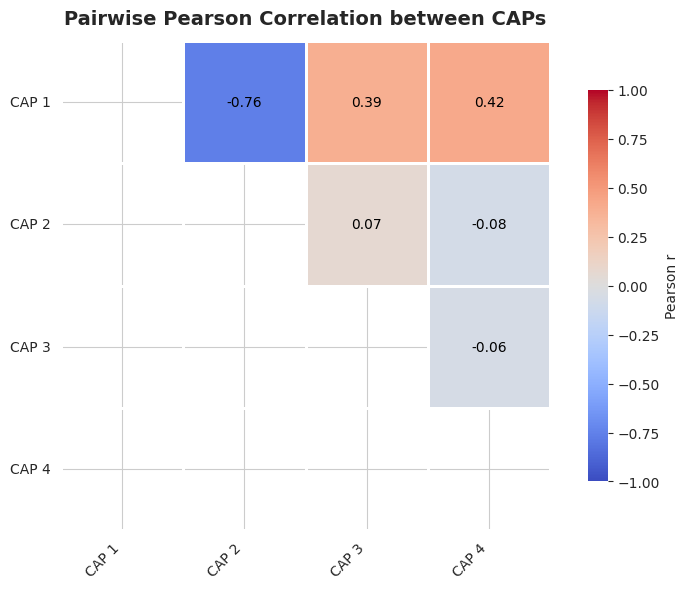

In [6]:
mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=0)
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.8,
    vmin=-1,
    vmax=1,
    cbar_kws={"shrink": 0.8, "label": "Pearson r"},
    xticklabels=[f"CAP {i+1}" for i in range(n_caps)],
    yticklabels=[f"CAP {i+1}" for i in range(n_caps)],
    annot_kws={"size": 10, "color": "black"},
)

plt.title("Pairwise Pearson Correlation between CAPs", fontsize=14, weight="bold", pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

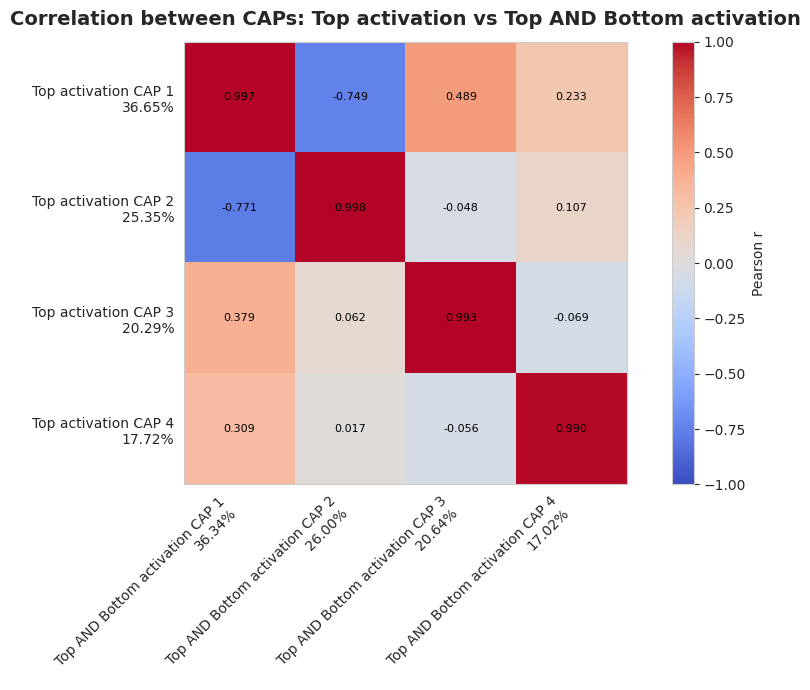

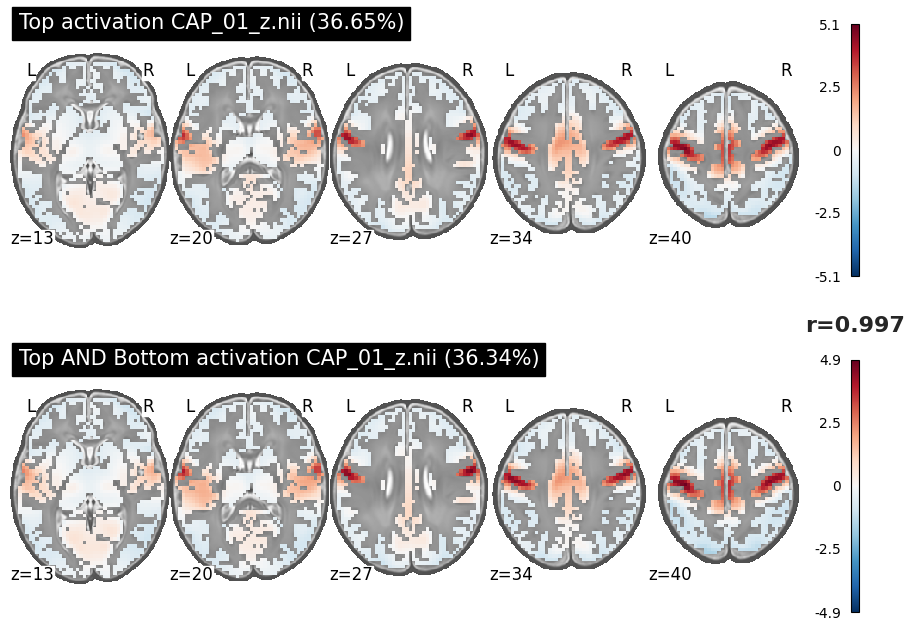

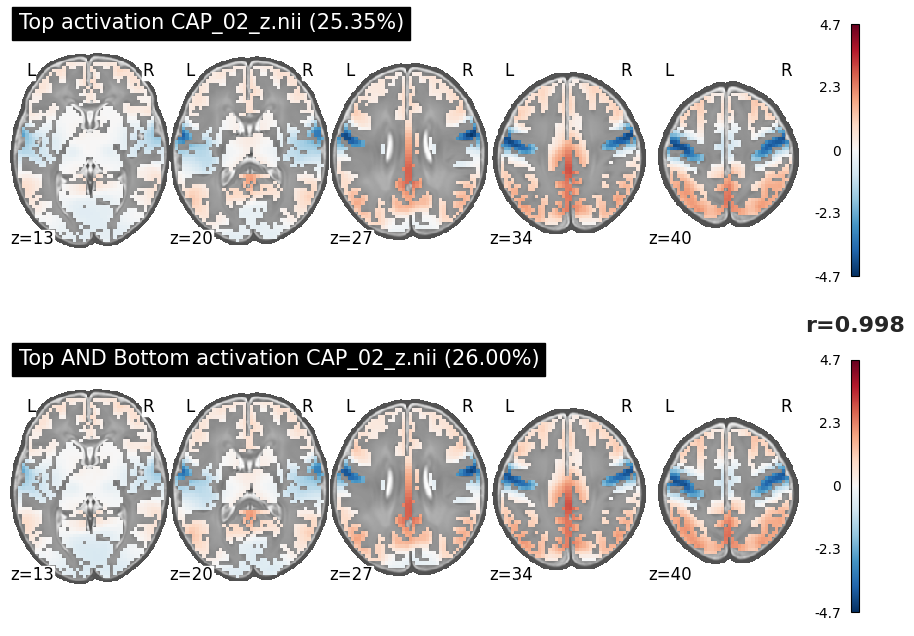

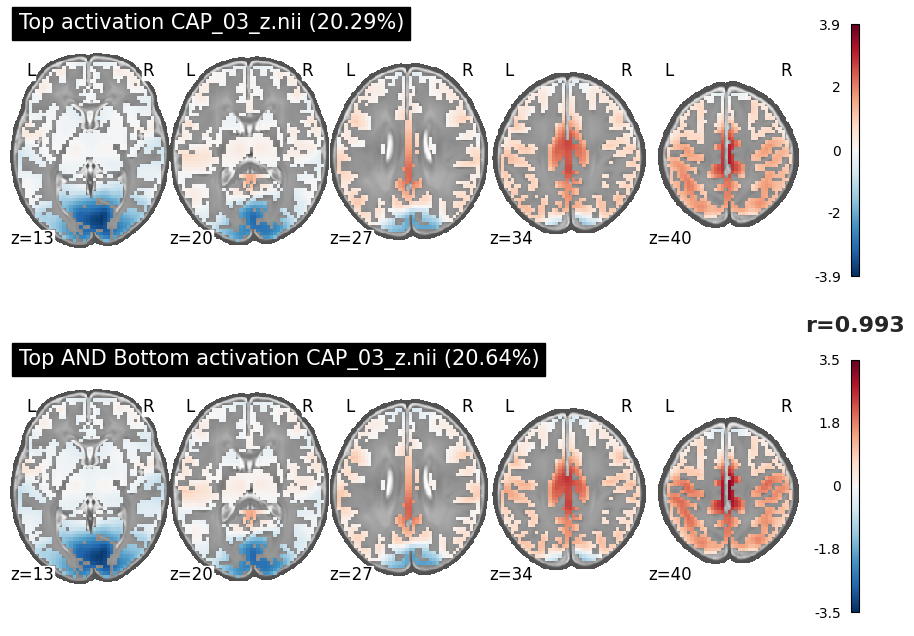

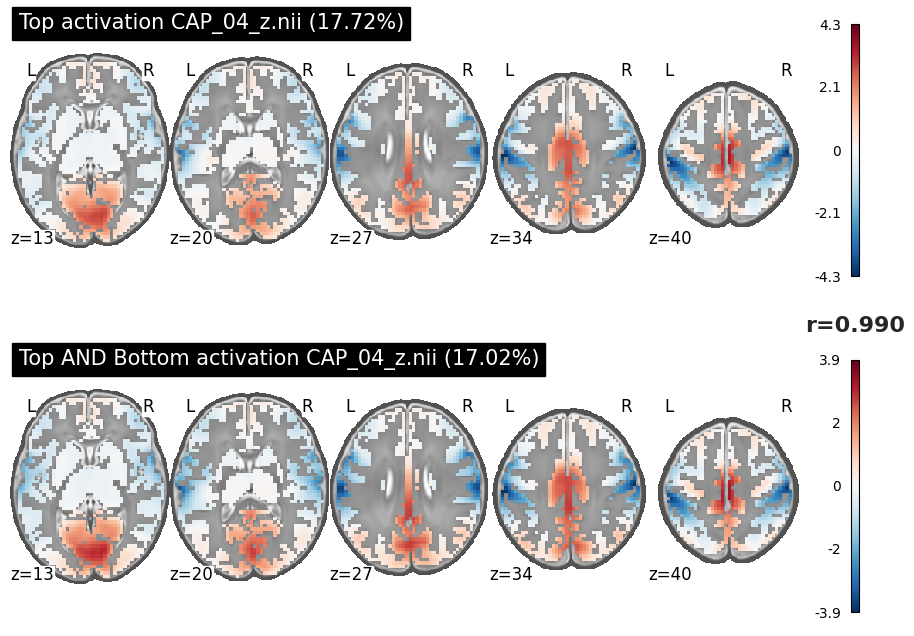

In [15]:
folderA = "vectorizedCorr_kmeans_dist-correlation_ttype-percentage_tvalue-15_k-4_ninits-50_activation-pos_n-481"
folderA_name = "Top activation"

folderB = "vectorizedCorr_kmeans_dist-correlation_ttype-percentage_tvalue-15_k-4_ninits-50_activation-both_n-481"
folderB_name = "Top AND Bottom activation"

folderA = paths.sample_derivatives / folderA
folderB = paths.sample_derivatives / folderB

# Collect CAP maps
cap_paths_A = sorted(folderA.glob("CAP_*_z.nii"))
cap_paths_B = sorted(folderB.glob("CAP_*_z.nii"))
if len(cap_paths_A) == 0 or len(cap_paths_B) == 0:
    raise FileNotFoundError("No CAP_*_z.nii files found in one or both folders.")

# Load cluster sizes
cluster_sizes_A = pd.read_pickle(folderA / paths.cluster_sizes_df_name)
cluster_sizes_B = pd.read_pickle(folderB / paths.cluster_sizes_df_name)

nA, nB = len(cap_paths_A), len(cap_paths_B)
corrs = np.zeros((nA, nB), dtype=float)

# Compute pairwise correlations and L2 distances
cap_data_A = [nib.load(p).get_fdata().ravel() for p in cap_paths_A]
cap_data_B = [nib.load(p).get_fdata().ravel() for p in cap_paths_B]

for i in range(nA):
    for j in range(nB):
        r, _ = pearsonr(cap_data_A[i], cap_data_B[j])
        corrs[i, j] = r

# --- Heatmap of correlations ---
plt.figure(figsize=(10, 7))
plt.imshow(corrs, cmap='coolwarm', vmin=-1, vmax=1)
for i in range(nA):
    for j in range(nB):
        plt.text(j, i, f"{corrs[i, j]:.3f}", ha='center', va='center', color='black', fontsize=8)
plt.colorbar(label='Pearson r')

plt.xticks(
    ticks=np.arange(nB),
    labels=[
        f"{folderB_name} CAP {j+1}\n{(cluster_sizes_B.iloc[j] / cluster_sizes_B.sum() * 100):.2f}%"
        for j in range(nB)
    ],
    rotation=45,
    ha='right'
)
plt.yticks(
    ticks=np.arange(nA),
    labels=[
        f"{folderA_name} CAP {i+1}\n{(cluster_sizes_A.iloc[i] / cluster_sizes_A.sum() * 100):.2f}%"
        for i in range(nA)
    ],
    rotation=0
)
plt.title(f"Correlation between CAPs: {folderA_name} vs {folderB_name}", fontsize=14, weight="bold", pad=12)
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Best matches & slice plots ---
best_matches = []
cut_coords = [13, 20, 27, 34, 40]
bg_img = paths.ext40Template

for i in range(nA):
    j_best = int(np.argmax(corrs[i, :]))
    r_best = corrs[i, j_best]
    best_matches.append((i, j_best, r_best))

    imgA = nib.load(cap_paths_A[i])
    imgB = nib.load(cap_paths_B[j_best])

    fig, axes = plt.subplots(2, 1, figsize=(11, 8))

    propA = cluster_sizes_A.iloc[i] / cluster_sizes_A.sum() * 100
    propB = cluster_sizes_B.iloc[j_best] / cluster_sizes_B.sum() * 100

    plotting.plot_stat_map(
        imgA,
        title=f"{folderA_name} {cap_paths_A[i].name} ({propA:.2f}%)",
        bg_img=bg_img,
        black_bg=False,
        display_mode="z",
        cut_coords=cut_coords,
        colorbar=True,
        axes=axes[0],
        figure=fig,
    )
    plotting.plot_stat_map(
        imgB,
        title=f"{folderB_name} {cap_paths_B[j_best].name} ({propB:.2f}%)",
        bg_img=bg_img,
        black_bg=False,
        display_mode="z",
        cut_coords=cut_coords,
        colorbar=True,
        axes=axes[1],
        figure=fig,
    )
    plt.title(f"r={r_best:.3f}", fontsize=16, weight="bold", pad=20)
    plt.show()